In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [143]:
meta_data = pd.read_csv('cluster_meta.csv')
print(meta_data.head())

def load_data(folder_path,meta_data):
    data = []
    for file in meta_data['cluster']:
        file = file + '.csv'
        file_path = os.path.join(folder_path,file)
        cluster = pd.read_csv(file_path,header=None).values
        cluster = cluster.flatten()
        cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
        data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array


meta_scaler = MinMaxScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])
print(meta_data.head())

   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0
   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0


In [144]:
def import_and_pad_csvs(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    data_arrays = []
    number_arrays = len(csv_files)
    number_large = 0
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    print(f"Index of the largest initial array: {largest_array_index}")
    padded_arrays = []
    for array in data_arrays:
        if array.shape[0] <= 64 and array.shape[1] <= 64:
            padded_array = np.zeros((64, 64))
            padded_array[:array.shape[0], :array.shape[1]] = array
            padded_arrays.append(padded_array)
            number_large += 1
    print(f'Number of arrays that are smaller than 64x64: {number_large}, ({number_large/number_arrays*100:.2f}%)')
    print(f'max rows: {max_rows}, max cols:{max_cols}')
    combined_array = np.stack(padded_arrays, axis=0)
    return combined_array

In [150]:
class NumpyArrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample  # Return only the sample and dummy label

folder_path = 'clusters_colour_rotations_rescaled'
combined_array = load_data(folder_path,meta_data)

scalar = MinMaxScaler()
combined_array = scalar.fit_transform(combined_array.reshape(-1, 1)).reshape(combined_array.shape)
print(combined_array.shape)


transform = transforms.Compose([
    transforms.ToTensor()
])
#meta_data_values = NumpyArrayDataset(meta_data_values, transform=transform)
dataset = NumpyArrayDataset(combined_array, transform=transform)
print(combined_array.shape)

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(meta_data_values.shape)


# train_dataset, test_dataset, train_meta, test_meta = train_test_split(dataset, meta_data_values, test_size=0.2, random_state=42)
# test_dataset = dataset

# lazy, non-random split
test_size = 0.2
split_index = int(len(dataset) * (1 - test_size))
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]
train_meta = meta_data_values[:split_index]
test_meta = meta_data_values[split_index:]

shape of combined array: 
(3936, 4100)
(3936, 4100)
(3936, 4100)


In [154]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_loader.dataset[0].shape)

#train_meta = DataLoader(train_meta, batch_size=32, shuffle=False)
#test_meta = DataLoader(test_meta, batch_size=32, shuffle=False)

torch.Size([3148, 4100])


(array([1.613412e+07, 3.920000e+02, 2.240000e+02, 2.400000e+02,
        1.840000e+02, 1.440000e+02, 1.760000e+02, 2.160000e+02,
        1.760000e+02, 3.040000e+02, 1.680000e+02, 1.680000e+02,
        2.240000e+02, 1.120000e+02, 1.120000e+02, 1.120000e+02,
        6.400000e+01, 5.600000e+01, 1.600000e+01, 2.400000e+01,
        4.000000e+01, 6.400000e+01, 4.000000e+01, 1.600000e+01,
        8.000000e+00, 0.000000e+00, 2.400000e+01, 2.400000e+01,
        8.000000e+00, 8.000000e+00, 8.000000e+00, 1.600000e+01,
        8.000000e+00, 0.000000e+00, 8.000000e+00, 8.000000e+00,
        8.000000e+00, 0.000000e+00, 0.000000e+00, 8.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.600000e+01,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.600000e+01,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 8.000000e+00, 8.000000e+00,
        8.000000e+00, 0.000000e+00, 0.00

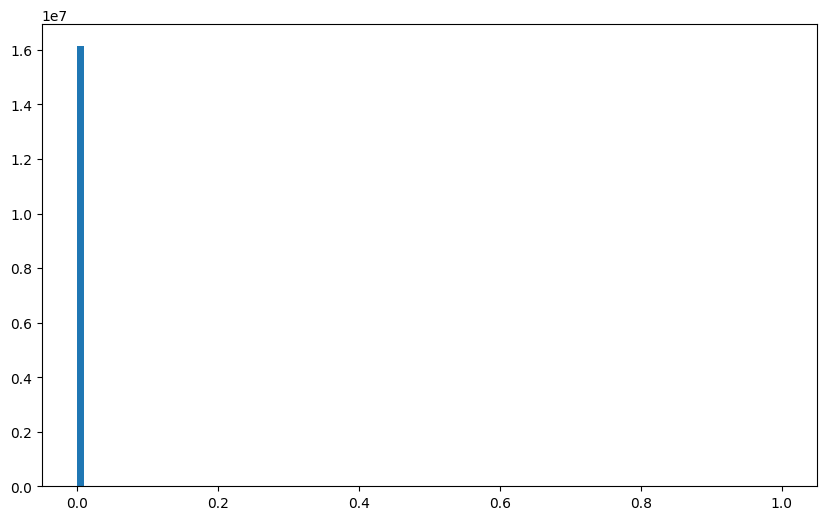

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(combined_array.flatten(), bins=100)

In [89]:
# fig, ax = plt.subplots()
# ax.imshow(combined_array[3929,:,:], cmap='gray')

In [308]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            # Keep 3D structure
            nn.Conv2d(1, 8, 8, stride=2, padding=1),  # 1x256x256 -> 8, 122, 122
            nn.ReLU(True),
            nn.Conv2d(8, 16 , 16, stride=2, padding=1),  # 8, 122, 122 -> [16, 47, 47]
            nn.BatchNorm2d(16),
            nn.ReLU(True),    
            )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=0)
 
        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(1296+4, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
   
    def forward(self, x):
        #print(x.shape)
        meta = x[-4:]
        
        #print(meta.shape)
        x = x[:-4].unflatten(0, (1,1, 64, 64))
        #x = x.unflatten(2, ( 64, 64))
        # x = x[:,:,:-4].reshape(1,3096,64,64)
        #print(x.shape)
        x = self.encoder_cnn(x)
        #print("Encoder CNN",x.shape)
        x = self.flatten(x)
        # if not isinstance(meta_data, torch.Tensor):
            # meta_data = torch.from_numpy(meta_data).to(x.device, dtype = x.dtype)
        # print(x.shape, meta_data.shape)
        #print(x.shape, meta.shape)
        y = torch.cat((x, meta), dim=0)
        #print(y.shape)
        x = self.encoder_lin(y)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1296),
            nn.ReLU(True)
        )

        ### The decoder does the exact opposite, reconstructing the images from the latent space values.
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(16, 9, 9))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16,16,16, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,1,8, stride=2, padding=1)
        )
        
    def forward(self, x):
        #print('Forward pass in Decoder',x.shape)
        x = self.decoder_lin(x).reshape((1,1296))
        #print("LinNN",x.shape)
        x = self.unflatten(x)
        #print("Unflatten",x.shape)
        x = self.decoder_conv(x)
        #print("Conv",x.shape)
        x = torch.sigmoid(x)
        return x

In [309]:
# print((train_loader.dataset[0][0]))
x = train_loader.dataset[0][0]
print(x.shape)
x = x[:-4].reshape((1,1,64,64))


# encoder:
A = nn.Conv2d(1, 8, 8, stride=2, padding=1)
B = nn.Conv2d(8, 16 , 16, stride=2, padding=1)
C = nn.BatchNorm2d(16)

# flatten
D = nn.Flatten()

# linear
E = nn.Linear(1296, 128)
F = nn.Linear(128, 10)

print(f'original data: {x.shape}')

print('encoder:')

print(f'Conv1: {A(x).shape}')
print(f'Conv2: {B(A(x)).shape}')
print(f'BatchNorm: {C(B(A(x))).shape}')
print(f'Flatten: {D(C(B(A(x)))).shape}')
print(f'Linear1: {E(D(C(B(A(x))))).shape}')
print(f'Linear2: {F(E(D(C(B(A(x)))))).shape}')



print('decoder:')


x = train_loader.dataset[0][0]
x = x[:-4].reshape((1,1,64,64))
x = F(E(D(C(B(A(x))))))
# decoder:
G = nn.Linear(10, 128)
H = nn.Linear(128, 1296)
I = nn.Unflatten(dim=1, 
        unflattened_size=(16, 9, 9))
J = nn.ConvTranspose2d(16, 16, 16, stride=2,padding = 1)#, output_padding=0)
K = nn.BatchNorm2d(16)
L = nn.ConvTranspose2d(16, 1, 8, stride=2, padding = 1)#, padding=1, output_padding=1)
# M = nn.BatchNorm2d(8)
# N = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

print(f'Linear1: {G(x).shape}')
print(f'Linear2: {H(G(x)).shape}')
print(f'Unflatten: {I(H(G(x))).shape}')
print(f'Conv1: {J(I(H(G(x)))).shape}')
print(f'BatchNorm: {K(J(I(H(G(x))))).shape}')
print(f'Conv2: {L(K(J(I(H(G(x)))))).shape}')

torch.Size([4100])
original data: torch.Size([1, 1, 64, 64])
encoder:
Conv1: torch.Size([1, 8, 30, 30])
Conv2: torch.Size([1, 16, 9, 9])
BatchNorm: torch.Size([1, 16, 9, 9])
Flatten: torch.Size([1, 1296])
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 10])
decoder:
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 1296])
Unflatten: torch.Size([1, 16, 9, 9])
Conv1: torch.Size([1, 16, 30, 30])
BatchNorm: torch.Size([1, 16, 30, 30])
Conv2: torch.Size([1, 1, 64, 64])


In [310]:
loss_fn = nn.MSELoss()
lr = 0.001
torch.manual_seed(42)

d = 28
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch in dataloader.dataset[0]:
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch[:-4].reshape(decoded_data.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


In [315]:
def test_epoch(encoder, decoder, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader.dataset[0]:
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch[:-4].reshape(decoded_data.shape).cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data



In [316]:
import time

In [317]:
diz_loss = {'train_loss': [], 'val_loss': []}

In [318]:
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(encoder, decoder, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, test_loader, loss_fn)
    elapsed_time = time.time() - start_time
    if epoch != 0:
        print(f'Epoch {epoch + 1}/{num_epochs} \t train loss: {train_loss:.2e} \t Delta: {diz_loss['train_loss'][-1]-train_loss:.5e} \t val loss: {val_loss:.5e} \t Delta: {diz_loss['val_loss'][-1]-val_loss:.2e} \t time: {elapsed_time}')
    else:
        print(f'Epoch {epoch + 1}/{num_epochs} \t train loss: {train_loss:.5e} \t val loss: {val_loss:.5e} \t time: {elapsed_time}')
    print(f'Elapsed time: {elapsed_time}')
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    #plot_ae_outputs(encoder, decoder, n=10)


Epoch 1/20 	 train loss: 5.33468e-06 	 val loss: 4.98704e-06 	 time: 65.06310272216797
Elapsed time: 65.06310272216797
Epoch 2/20 	 train loss: 4.36e-06 	 Delta: 9.71258e-07 	 val loss: 3.68387e-06 	 Delta: 1.30e-06 	 time: 85.57879829406738
Elapsed time: 85.57879829406738


In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(diz_loss['train_loss'], label='train loss')
ax.plot(diz_loss['val_loss'], label='val loss')
ax.legend()
# ax.set_xlim(0, 50)


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

In [ ]:
encoder.eval()
decoder.eval()

In [ ]:
# sumf = 0
# for i in range(6400):
#     img = test_dataset[i][0].unsqueeze(0).numpy()
#     suming = np.sum(img)
#     if suming>sumf:
#         sumf = sumimg
#         idx = i
# print(i)
# print(sumf)

In [ ]:
# evaluate model on radoom image
img = test_dataset[11][0].unsqueeze(0)
with torch.no_grad():
    rec_img = decoder(encoder(img))
    rec_img = rec_img.squeeze().numpy()
    img = img.squeeze().numpy()0
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(rec_img, cmap='gray')
    ax[1].set_title('Reconstructed image')

In [ ]:
save = False
if save:
    # Function to save the model
    model_name = '64x64_MinMaxScaler'
    def save_model(encoder, decoder, encoder_path="encoder.pth", decoder_path="decoder.pth"):
        torch.save(encoder.state_dict(), encoder_path)
        torch.save(decoder.state_dict(), decoder_path)
        print("Models saved to {} and {}".format(encoder_path, decoder_path))
    enc = 'training_results/' + model_name + '/encoder.pth'
    dec = 'training_results/' + model_name + '/decoder.pth'
    save_model(encoder, decoder, encoder_path=enc, decoder_path=dec)
    np.savetxt('training_results/' + model_name + '/train_loss.txt', diz_loss['train_loss'])
    np.savetxt('training_results/' + model_name + '/val_loss.txt', diz_loss['val_loss'])

In [ ]:
def plot_initial_convolutions(encoder, num_filters=8, figsize=(15, 15)):
    """
    Plots the initial convolutional filters of the encoder.
    
    Parameters:
    - encoder: The trained encoder model.
    - num_filters: Number of filters to plot. Default is 16.
    - figsize: Size of the plot. Default is (15, 15).
    """
    # Extract the weights from the first convolutional layer
    conv1_weights = encoder.encoder_cnn[0].weight.data.cpu().numpy()
    
    # Create a figure to plot the filters
    fig, axes = plt.subplots(1, num_filters, figsize=figsize)
    
    for i in range(num_filters):
        ax = axes[i]
        # Get the filter
        filt = conv1_weights[i, 0, :, :]
        # Plot the filter
        ax.imshow(filt, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    
    plt.show()

# Usage example
plot_initial_convolutions(encoder)


In [ ]:
# Function to plot the latent space
